In [17]:
import numpy as np
import os
import matplotlib.pyplot as plt
import h5py
from scipy import interpolate
from ccfj import GetStationPairs
import pandas as pd
import yaml
import geopandas as gp
import openpyxl
from openpyxl import load_workbook
from concurrent.futures import ThreadPoolExecutor

from scipy.interpolate import make_interp_spline
from scipy.stats import ks_2samp
from scipy.spatial import ConvexHull
from skimage import measure

import warnings

In [18]:
import sys
sys.path.append(r'../tools_F-J/')
from toollib_standard import plotlib

In [19]:
#name_project = 'project/output_FJSJ_17-01/'               
name_project = 'project_repartition_v3.0/output_repar_01-01/'               
name_project

'project_repartition_v3.0/output_repar_01-01/'

In [20]:
with open('0_config.yml', 'r', encoding='utf-8') as f:
    dir_config = yaml.load(f.read(), Loader=yaml.FullLoader)
dir_project_workspace = dir_config['dir_project_workspace']
dir_CC_workspace = dir_config['dir_CC_workspace']
print('dir_CC_workspace: ', dir_CC_workspace)
print('dir_project_workspace: ', dir_project_workspace)
dir_project = os.path.join(dir_project_workspace, name_project)
print('dir_project: ', dir_project)

dir_CC_workspace:  /shdisk/rem2/Harmon/F-J/San/
dir_project_workspace:  /shdisk/rem2/Harmon/F-J/San/
dir_project:  /shdisk/rem2/Harmon/F-J/San/project_repartition_v3.0/output_repar_01-01/


In [21]:
filename = dir_project+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project+'Basic_info.npy'
info_basic_bi = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

In [22]:
key_subworks = info_basic['key_subworks']
key_subworks

['07-03--1',
 '09-03--2',
 '10-03--3',
 '11-03--4',
 '12-03--5',
 '13-03--6',
 '14-03--7',
 '16-03--8',
 '17-03--9',
 '18-03--10',
 '19-03--11',
 '20-03--12',
 '21-03--13',
 '22-03--14',
 '23-03--15',
 '24-03--16',
 '25-03--17',
 '26-03--18',
 '27-03--19',
 '28-03--20',
 '29-03--21',
 '31-03--22',
 '32-03--23',
 '34-03--24',
 '36-03--25',
 '37-03--26',
 '38-03--27',
 '39-03--28',
 '43-03--31',
 '45-03--32',
 '46-03--33',
 '47-03--34',
 '48-03--35',
 '49-03--36',
 '52-03--37',
 '53-03--38',
 '54-03--39',
 '07-04--40',
 '08-04--41',
 '09-04--42',
 '10-04--43',
 '11-04--44',
 '12-04--45',
 '14-04--46',
 '15-04--47',
 '16-04--48',
 '18-04--49',
 '19-04--50',
 '20-04--51',
 '21-04--52',
 '22-04--53',
 '23-04--54',
 '24-04--55',
 '25-04--56',
 '26-04--57',
 '27-04--58',
 '28-04--59',
 '29-04--60',
 '30-04--61',
 '31-04--62',
 '32-04--63',
 '33-04--64',
 '36-04--65',
 '39-04--66',
 '40-04--67',
 '43-04--68',
 '45-04--69',
 '46-04--70',
 '47-04--71',
 '48-04--72',
 '49-04--73',
 '52-04--74',
 

In [23]:
dir_image = dir_project+info_basic['dir_image']
dir_ds = dir_project+info_basic['dir_ds']
print('dir_image: ', dir_image)
print('dir_ds: ', dir_ds)

dir_image:  /shdisk/rem2/Harmon/F-J/San/project_repartition_v3.0/output_repar_01-01/image_01-01/
dir_ds:  /shdisk/rem2/Harmon/F-J/San/project_repartition_v3.0/output_repar_01-01/ds_01-01/


In [24]:
dir_disp =  'autopick'+info_basic['tag']+'/'
info_basic['dir_disp'] = dir_disp
dir_disp = dir_project+dir_disp
if not os.path.exists(dir_disp):
    os.makedirs(dir_disp)
print('dir_disp: ', dir_disp)

dir_disp:  /shdisk/rem2/Harmon/F-J/San/project_repartition_v3.0/output_repar_01-01/autopick01-01/


In [25]:
with open(dir_project+'Basic_info.yml', 'w', encoding='utf-8') as f:
   yaml.dump(data=info_basic, stream=f, allow_unicode=True)

### Pick probes' Phase velocity automatically

In [26]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [27]:
def cluster_fundamental(ds):
    global f
    global c
    global f_new
    global c_new
    global dir_ds
    global threshold
    # 归一化
    ds = np.nan_to_num(ds)
    for i in range(ds.shape[1]):
        ds[:,i] = ds[:,i]/np.max(ds[:,i])

    binary_ds = ds > threshold
    label_ds,num_labels = measure.label(binary_ds, connectivity=2, return_num=True)
    region_areas = [np.sum(label_ds==i) for i in range(1,num_labels+1)]
    if num_labels == 0:
        return np.zeros(0),np.zeros(0)
    max_area_label = np.argmax(region_areas) + 1
    largest_cluster = label_ds == max_area_label
    indices = np.argwhere(largest_cluster)

    ff = f_new[indices[:,1]]
    cc = c_new[indices[:,0]]

    return ff,cc

In [28]:
def pick_fundamental(key):
    global f
    global c
    global f_new
    global c_new
    global flag_f
    global flag_c
    global dir_ds
    global threshold
    global dir_disp
    global dir_ds
    global info_basic
    global info_basic_bi
    global smooth_cluster
    global smooth_pick
    global key_subworks
    global ds_remove_all

    
    ds_remove = ds_remove_all[key]
    grace = 0.0

    f_start = flag_f[0]
    f_end = flag_f[1]
    c_min = flag_c[0]
    c_max = flag_c[1]

    ff_all = []
    cc_all = []


    while f_start != f_end:
        #print(f_start,f_end)
        f_new = f[np.logical_and(f>f_start,f <= f_end)]
        c_new = c[np.logical_and(c>c_min,c < c_max)]
        ds_new0 = ds_remove[np.logical_and(c>c_min,c < c_max),:]
        ds_new = ds_new0[:,np.logical_and(f>f_start,f <= f_end)]
        # 对数组进行横向的平滑
        ds_new = pd.DataFrame(ds_new)
        #ds_new = ds_new.rolling(100).mean()
        ds_new = ds_new.T
        ds_new = ds_new.rolling(smooth_cluster).mean()
        ds_new = np.array(ds_new)
        ds_new = ds_new.T
        ff,cc = cluster_fundamental(ds_new)
        if len(ff_all) == 0:
            ff_all = ff
            cc_all = cc
        elif len(ff) != 0:
            ff_all = np.hstack((ff_all,ff))
            cc_all = np.hstack((cc_all,cc))
        else:
            #print('this')
            break
        f_start = np.max(ff)
        c_max = np.max(cc[ff==f_start]) + grace
    
    # smooth
    # 转置
    ds_smooth = ds_remove.T
    ds_smooth = pd.DataFrame(ds_smooth)
    ds_smooth = ds_smooth.rolling(smooth_pick).mean()
    ds_smooth = np.array(ds_smooth)
    ds_smooth = ds_smooth.T
    ds_smooth = pd.DataFrame(ds_smooth)
    ds_smooth = ds_smooth.rolling(smooth_pick).mean()
    ds_smooth = np.array(ds_smooth)

    f_range = set(ff_all)
    f_range = list(f_range)
    c_pick = []
    for i in range(len(f_range)):
        f_this = f_range[i]
        c_this = cc_all[ff_all==f_this]
        c_range = [np.min(c_this),np.max(c_this)]
        c_new = c[np.logical_and(c>=c_range[0],c<=c_range[1])]
        c_pick.append(c_new[np.argmax(ds_smooth[np.logical_and(c>=c_range[0],c<=c_range[1]),f==f_this])])
    
    # save as txt
    np.savetxt(dir_disp+'autopick_cluster_'+key+'.txt', np.array([ff_all,cc_all]).T, fmt='%.4f', delimiter=',')
    np.savetxt(dir_disp+'autopick_'+key+'.txt', np.array([f_range,c_pick]).T, fmt='%.4f', delimiter=',')
    print('finish '+ key + ' '+str(key_subworks.index(key)+1) + '/'+str(len(key_subworks)))

In [29]:
key_subworks_all = info_basic['key_subworks']
key_subworks = []
for key in key_subworks_all:
    if int(key[0:2]) >= 46:
        key_subworks.append(key)
key_subworks = ['51-17--646']
key_subworks = info_basic['key_subworks'][600:]
key_subworks

['18-18--658',
 '19-18--659',
 '20-18--660',
 '21-18--661',
 '22-18--662',
 '24-18--663',
 '28-18--664',
 '29-18--665',
 '33-18--666',
 '34-18--667',
 '35-18--668',
 '36-18--669',
 '37-18--670',
 '43-18--674',
 '45-18--676',
 '46-18--677',
 '47-18--678',
 '49-18--679',
 '51-18--680',
 '52-18--681',
 '54-18--682']

In [30]:
nums_repick =[127,137,231,232,366,384,411,412,456,466,467,489,501,502,503,504,507,508,515,516,519,528,530,532,534,544,545,538,546,573,578,579,581,582,589,591,592,593,597,603,604,616,617,634,635,636,637,640,661,662,664,665,667,668]
key_subworks = []
for num in nums_repick:
    tag = str(num)
    key_ds0 = [key_subwork for key_subwork in info_basic['key_subworks'] if tag == key_subwork[-len(str(tag)):]][0]
    key_subworks.append(key_ds0)

In [31]:
ds_remove_all = {}
for key_subwork in key_subworks:
    ds = h5py.File(dir_ds+'ds_'+key_subwork+'.h5', 'r')
    ds_remove = ds['ds_remove'][0]
    ds.close()
    ds_remove_all[key_subwork] = ds_remove

In [32]:
f = info_basic_bi['f']
c = np.linspace(info_basic['c_min'],info_basic['c_max'],info_basic['c_num'])
flag_c = [0.1,1.5]
flag_f = [2.5,20]
threshold = 0.5
f_new = f[np.logical_and(f>flag_f[0],f < flag_f[1])]
c_new = c[np.logical_and(c>flag_c[0],c < flag_c[1])]
smooth_cluster = 3
smooth_pick = 1
flag_pick = 1

In [33]:
warnings.filterwarnings("ignore")
if flag_pick == 1:
    for key_subwork in key_subworks:
        pick_fundamental(key_subwork)

finish 16-06--127 1/54
finish 26-06--137 2/54
finish 39-08--231 3/54
finish 40-08--232 4/54
finish 43-11--366 5/54
finish 13-12--384 6/54
finish 40-12--411 7/54
finish 42-12--412 8/54
finish 40-13--456 9/54
finish 50-13--466 10/54
finish 51-13--467 11/54
finish 26-14--489 12/54
finish 38-14--501 13/54
finish 39-14--502 14/54
finish 40-14--503 15/54
finish 41-14--504 16/54
finish 44-14--507 17/54
finish 45-14--508 18/54
finish 53-14--515 19/54
finish 54-14--516 20/54
finish 11-15--519 21/54
finish 20-15--528 22/54
finish 22-15--530 23/54
finish 24-15--532 24/54
finish 26-15--534 25/54
finish 38-15--544 26/54
finish 39-15--545 27/54
finish 31-15--538 28/54
finish 40-15--546 29/54
finish 22-16--573 30/54
finish 27-16--578 31/54
finish 28-16--579 32/54
finish 30-16--581 33/54
finish 31-16--582 34/54
finish 38-16--589 35/54
finish 40-16--591 36/54
finish 41-16--592 37/54
finish 42-16--593 38/54
finish 46-16--597 39/54
finish 52-16--603 40/54
finish 53-16--604 41/54
finish 19-17--616 42/54
f

In [34]:
def plot_disp(key_subwork):
    global dir_disp
    global f
    global c
    global dir_image_disp

    fig,ax = plt.subplots(1,2,figsize=(16,6))
    dir_ds = dir_project + info_basic['dir_ds']
    ds = h5py.File(dir_ds+'ds_'+key_subwork+'.h5', 'r')
    ds_remove = ds['ds_remove'][0]

    title0 = key_subwork
    ff_all = np.loadtxt(dir_disp+'autopick_cluster_'+key_subwork+'.txt',delimiter=',')[:,0]
    cc_all = np.loadtxt(dir_disp+'autopick_cluster_'+key_subwork+'.txt',delimiter=',')[:,1]
    f_pick = np.loadtxt(dir_disp+'autopick_'+key_subwork+'.txt',delimiter=',')[:,0]
    c_pick = np.loadtxt(dir_disp+'autopick_'+key_subwork+'.txt',delimiter=',')[:,1]

    ax[0] = plotlib.plot_fj(ax[0],ds_remove,title0,f,c,0,c_map='jet')
    ax[0].scatter(ff_all,cc_all,marker='o',s=10,color='k')
    
    ax[1] = plotlib.plot_fj(ax[1],ds_remove,title0,f,c,0,c_map='jet')
    ax[1].scatter(f_pick,c_pick,marker='o',s=10,color='k')

    plt.savefig(dir_image_disp+'autopick_'+key_subwork+'.png',dpi=60)
    plt.tight_layout()
    #plt.close()
    print('finish '+key_subwork)

In [35]:
dir_image_disp = 'image_autopick/'
if not os.path.exists(dir_project+dir_image_disp):
    os.makedirs(dir_project+dir_image_disp)
dir_image_disp = dir_project+dir_image_disp

In [36]:
flag_plot = 1

In [37]:
key_subworks = key_subworks[0:3]

finish 16-06--127
finish 26-06--137
finish 39-08--231


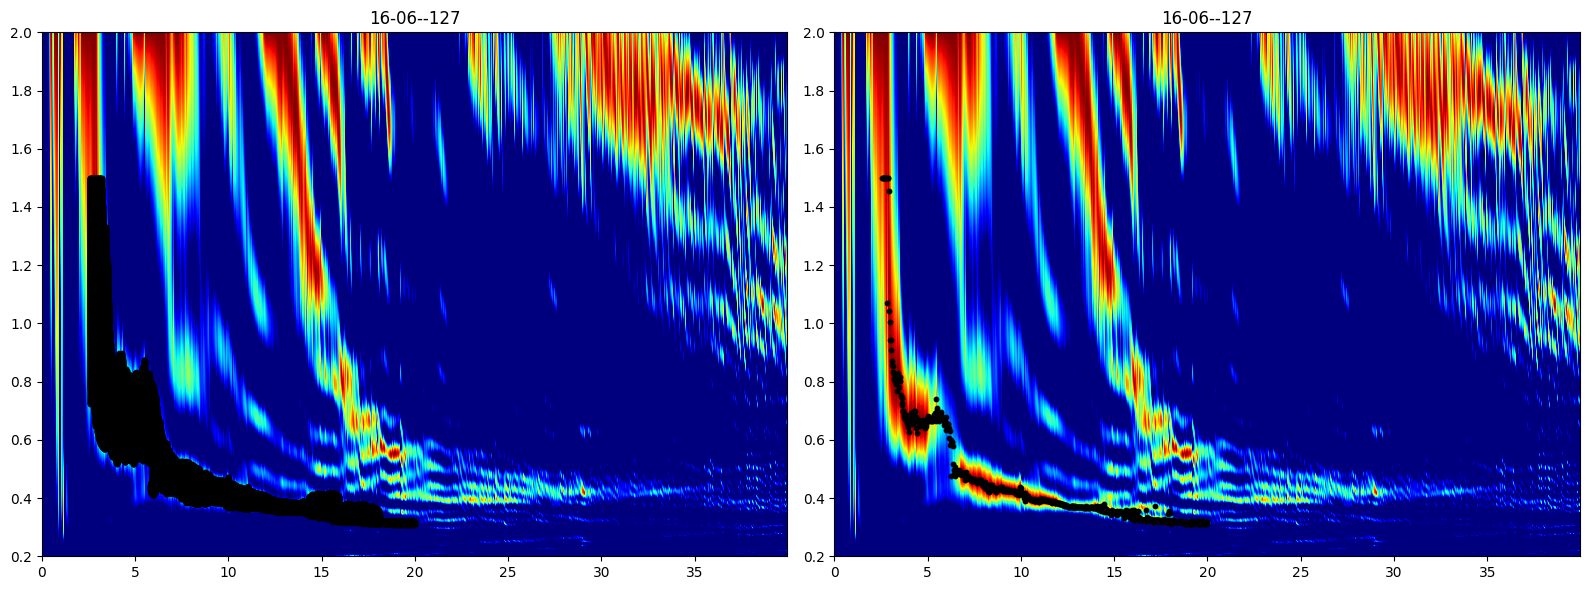

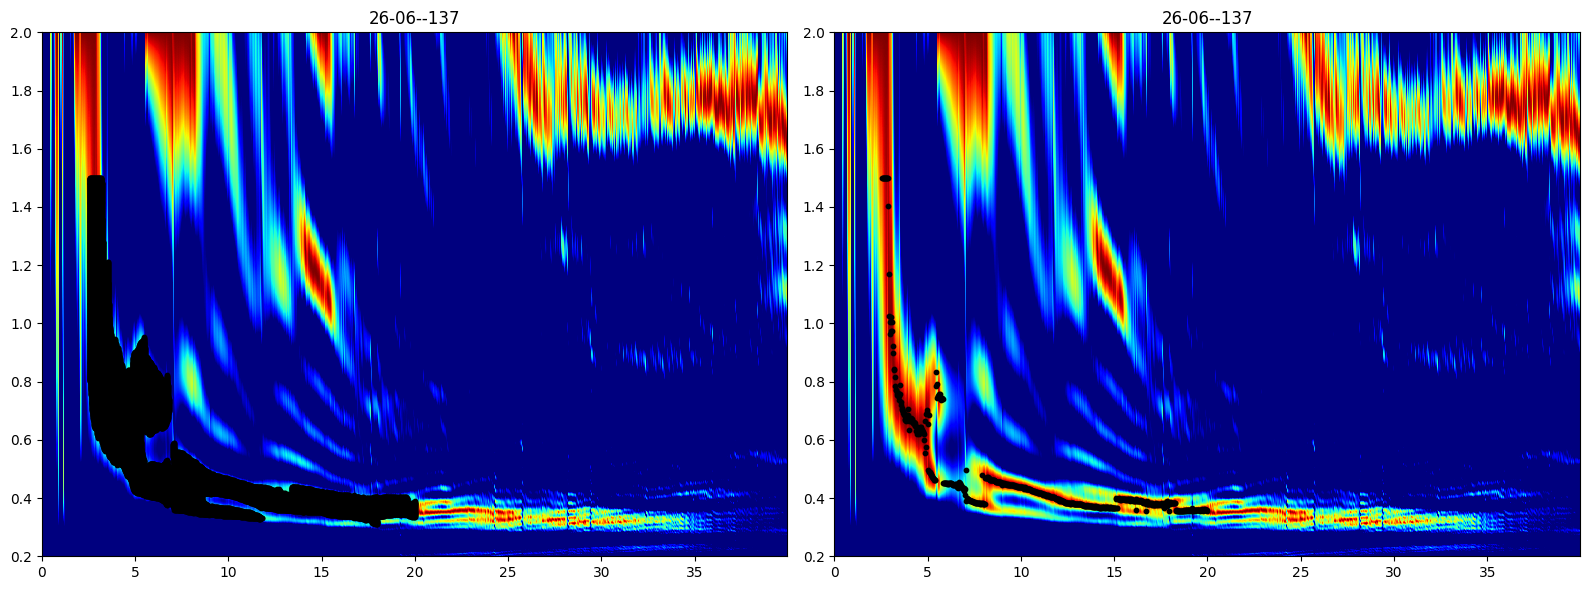

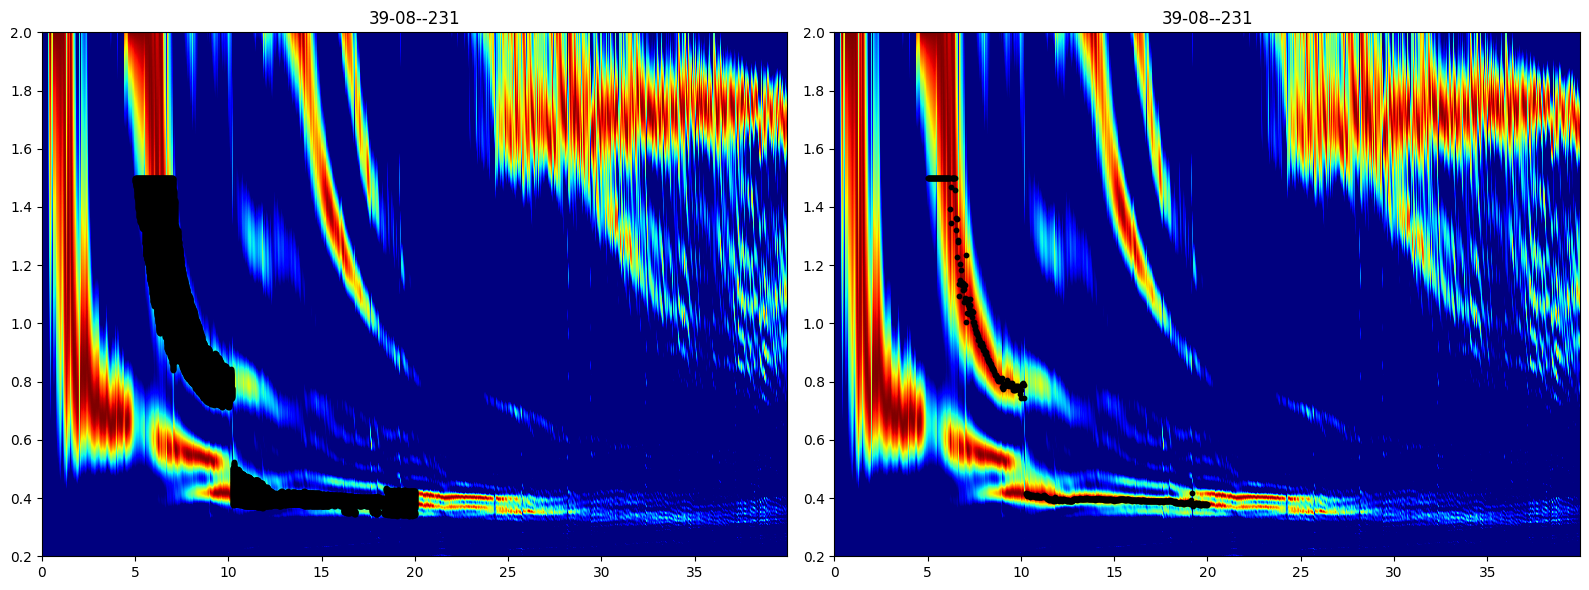

In [38]:
if flag_plot == 1:
    for key_subwork in key_subworks:  
        plot_disp(key_subwork)